# Qiskit Primitives -- Transverse Field Icy Model Circuit

In [ ]:
# This is based on the following Nature paper written by IBM Quantum: 
# https://www.nature.com/articles/s41586-023-06096-3

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import YGate, UnitaryGate #UnitaryGate lets you create new quantum gates
import numpy as np

SYGate = UnitaryGate(YGate().power(1/2), label =r"$\sqrt{Y}$") #Create SY gate
SYdGate = UnitaryGate(SYGate.inverse(), label =r"$\sqrt{Y^\dag}$") #Create SYd gate

def generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, num_cl_bits = 0, trotter_barriers = False, layer_barriers = False):
    if num_cl_bits == 0:
        qc = QuantumCircuit(num_qubits)
    else: 
        qc = QuantumCircuit(num_qubits, num_cl_bits)

    for trotter_step in range(num_trotter_steps): #Trotter steps = time evolution of a quantum system
        add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
        if trotter_barriers: #is true
            qc.barrier()

    return qc

def add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers = False):
    # Adding Rzz in the even layers
    for i in range(0, qc.num_qubits-1, 2): #Starts on 0, which is even: 0, 2, 4, ...
        qc.sdg([i, i+1])
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdGate, [i+1])
        if layer_barriers:
            qc.barrier()
    
    # Adding Rzz in the odd layers
    for i in range(1, qc.num_qubits-1, 2): #Starts on 1, which is odd: 1, 3, 5, ...
        qc.sdg([i, i+1])
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdGate, [i+1])
    if layer_barriers:
        qc.barrier()
    
    qc.rx(rx_angle, list(range(qc.num_qubits))) #Applies rx gate to all qubits in qc
    if layer_barriers:
        qc.barrier()

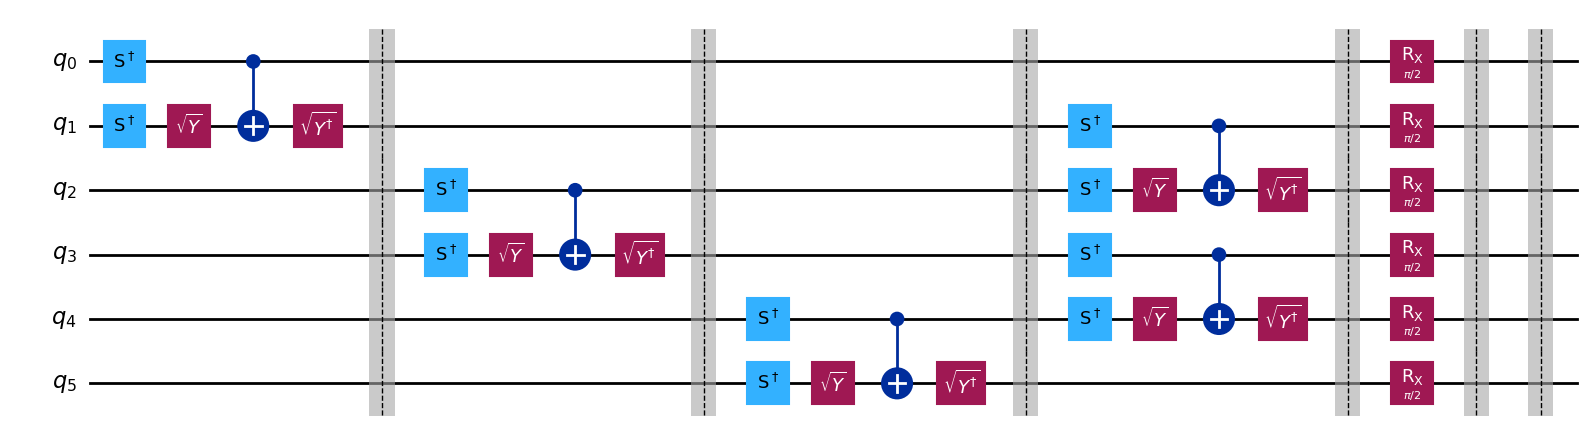

In [40]:
num_qubits = 6
num_trotter_steps = 1 #how many times you repeat the trotter-suzuki decomposition to estimate the time evolution (more = better)
rx_angle = 0.5 * np.pi

qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, trotter_barriers = True, layer_barriers = True)
qc.draw(output = 'mpl', fold = -1) #Fold puts everything on 1 line

# Sampler



In [41]:
# Showing how we can collect info on a bitstring-by-bitstring level (counts)

def append_generate_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers = False, layer_barriers = False):

    for trotter_step in range(num_trotter_steps): #Trotter steps = time evolution of a quantum system
        add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
        if trotter_barriers: #is true
            qc.barrier()

def add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers = False):
    
    qc.rx(-rx_angle, list(range(qc.num_qubits))) #Applies rx gate to all qubits in qc
    if layer_barriers:
        qc.barrier()

    # Adding Rzz in the odd layers
    for i in range(1, qc.num_qubits-1, 2): #Starts on 1, which is odd: 1, 3, 5, ...
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1) #is it's own inverse
        qc.append(SYdGate, [i+1])
        qc.s([i, i+1])
    if layer_barriers:
        qc.barrier()
    
    # Adding Rzz in the even layers
    for i in range(0, qc.num_qubits-1, 2): #Starts on 1, which is odd: 1, 3, 5, ...
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1) #is it's own inverse
        qc.append(SYdGate, [i+1])
        qc.s([i, i+1])
    if layer_barriers:
        qc.barrier()

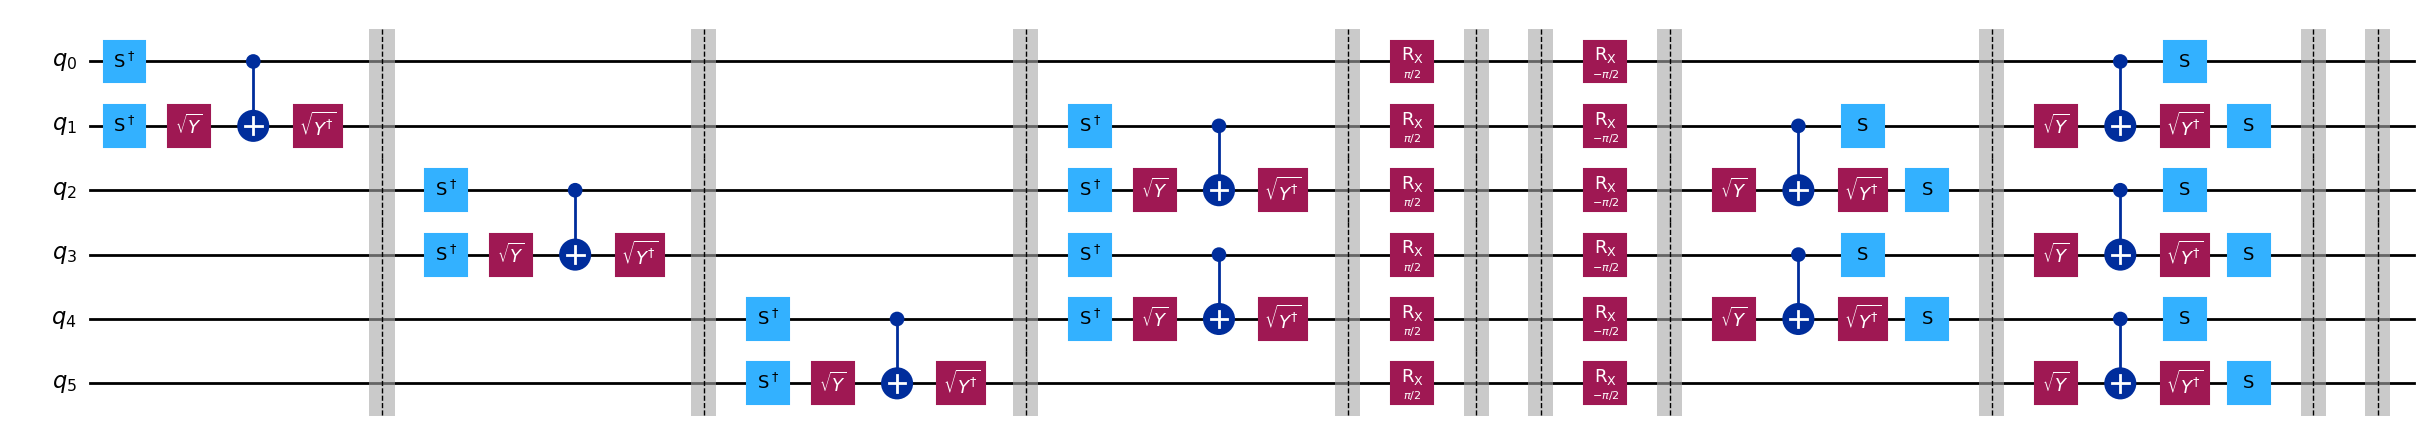

In [42]:
append_generate_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers = True, layer_barriers = True)
qc.draw(output = 'mpl', fold = -1)

# Step 1: Mapping

In [51]:
# Map the problem to circuits and observables (problem = noise grows as circuit depth increases --> increase # trotter steps + invert qc at each step --> to see survival % of each bitstring)

max_trotter_steps = 10
num_qubits = 100
measured_qubits = [49, 50] #measure qubits 49 & 50

qc_list = []
for trotter_step in range(max_trotter_steps):
    qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, num_cl_bits = len(measured_qubits), trotter_barriers = True, layer_barriers = True)
    append_generate_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers = True, layer_barriers = True)
    qc.measure(measured_qubits, list(range(len(measured_qubits))))
    qc_list.append(qc)

# Step 2: Optimize

In [94]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = "ibm_brisbane"
#QiskitRuntimeService.save_account(token = '03f980de3079f51ce8bb9dfae5a436674ad63137bd194a0c1fe78f9572089bc2cf73549b2b183f038cd1dad3015cbdf8e9bc127301a282c77253ac77251daf12', channel = 'ibm_quantum')
service = QiskitRuntimeService()
backend = service.backend(backend_name)
print("Done getting the backend")

qc_transpiled_list = transpile(qc_list, backend = backend, optimization_level = 1)

Done getting the backend


# Step 3: Execute

In [98]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import Session

with Session(backend=backend) as session:
    sampler = Sampler()

    sampler.options.dynamical_decoupling.enable = True
    sampler.options.dynamical_decoupling.sequence_type = "XY4"

    job = sampler.run(qc_transpiled_list)
    print(job.job_id())

/opt/anaconda3/envs/cwq/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:863: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


d18fa20v3z500083dsn0


# Step 4: Post-Process


In [99]:
# Post-processing and plotting

job_id = "d18fa20v3z500083dsn0"
job = service.job(job_id)

survival_probability_list = []
for trotter_step in range(max_trotter_steps):
    try:
        data = job.result()[trotter_step].data
        survival_probability_list.append(data.c.get_counts()['0' * len(measured_qubits)] / data.c.num_shots) #to get survival probability
    except:
        survival_probability_list.append(0)

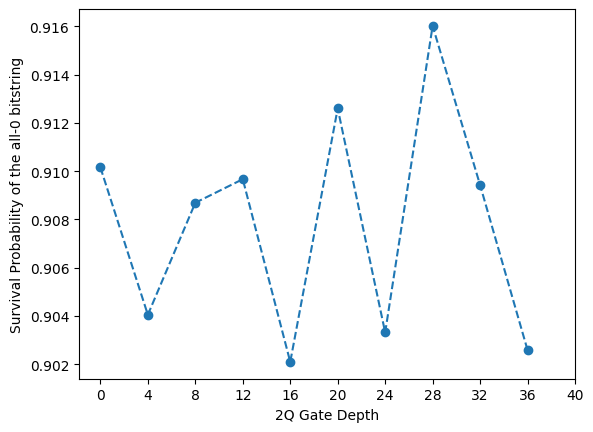

In [105]:
import matplotlib.pyplot as plt

plt.plot(list(range(0, 4 * max_trotter_steps, 4)), survival_probability_list, '--o')
plt.xlabel('2Q Gate Depth')
plt.ylabel('Survival Probability of the all-0 bitstring')
plt.xticks(np.arange(0, 44, 4))
plt.show()

# Estimator

# Step 1: Mapping

In [118]:
# Map the problem

from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp

rx_angle = Parameter("rx_angle")
trotter_steps = 2
qc = generate_1d_tfim_circuit(num_qubits, trotter_steps, rx_angle)

middle_index = num_qubits // 2
observable = SparsePauliOp("I" * middle_index + "Z" + "I" * (middle_index-1))

# Step 2: Optimize

In [119]:
# Optimize the circuit

from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = 'ibm_brisbane'
service = QiskitRuntimeService()
backend = service.backend(backend_name) #no longer get_backend.() --> .backend()

qc_transpiled = transpile(qc, backend = backend, optimization_level = 1)
observable = observable.apply_layout(qc_transpiled.layout)

# Step 3: Execute

In [120]:
# Execute on quantum hardware

from qiskit_ibm_runtime import EstimatorV2, EstimatorOptions

min_rx_angle = 0
max_rx_angle = np.pi/2
num_rx_angle = 12
rx_angle_list = np.linspace(min_rx_angle, max_rx_angle, num_rx_angle)

options = EstimatorOptions()
options.resilience_level = 1
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

with Session(backend=backend) as session:
    estimator = EstimatorV2()

    job = estimator.run([(qc_transpiled, observable, rx_angle_list)])
    print(job.job_id())

/opt/anaconda3/envs/cwq/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:863: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


d18h7anqf56g0082hs8g


# Post-Process

(-0.1, 1.1)

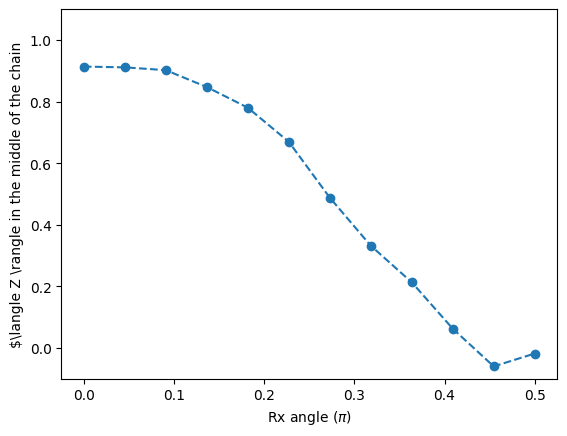

In [122]:
# Post-processing and plotting

job_id = "d18h7anqf56g0082hs8g"
job = service.job(job_id)

exp_val_list = job.result()[0].data.evs

plt.plot(rx_angle_list / np.pi, exp_val_list, '--o')
plt.xlabel(r'Rx angle ($\pi$)')
plt.ylabel(r'$\langle Z \rangle in the middle of the chain')
plt.ylim(-0.1, 1.1)